# Conditional Variational AutoEncoder

# Import de librairies

In [1]:
import os
import re
import random
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import inception_v3
import random
from torchvision.utils import save_image

import os
import torch
import torch.nn.functional as F

from pytorch_fid import fid_score

import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Qu'est-ce qu'un CVAE ?

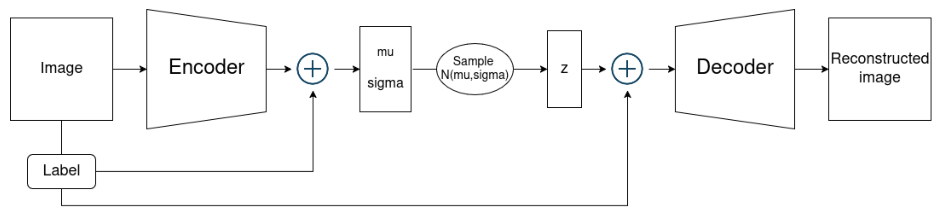

In [2]:
# Charger l'image
img = mpimg.imread('schema.png')

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

La différence avec un VAE est la prise en compte du label, ce qui permettra de générer une image d'un label donné.

# 1. Entraînement de plusieurs CVAE

## 1.1. Préparation des données FashionMnist

100%|█████████████████████████| 26421880/26421880 [00:00<00:00, 36599601.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████| 29515/29515 [00:00<00:00, 1515719.60it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████| 4422102/4422102 [00:00<00:00, 19317822.37it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 6056739.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



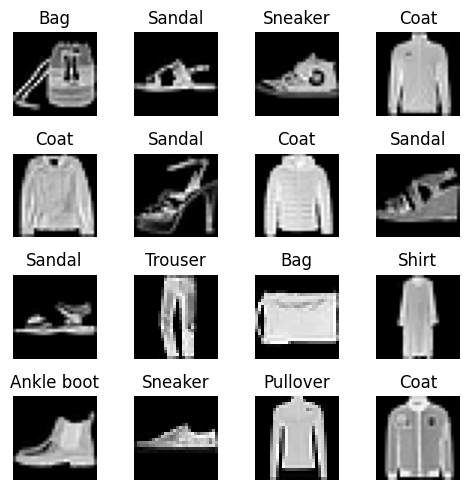

Taille du jeu d'entraînement: 48000
Taille du jeu de validation: 12000
Taille du jeu de test: 10000


In [3]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
val_split = 0.2
val_size = int(len(train_dataset) * val_split)
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
label_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
def show_images_from_loader(data_loader, label_names, num_images=16):
    images, labels = next(iter(data_loader))
    images = images[:num_images]  
    labels = labels[:num_images]  
    
    # Configuration de la grille d'affichage
    num_cols = int(np.sqrt(num_images))
    num_rows = int(np.ceil(num_images / num_cols))
    
    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")  # Supprime la dimension des canaux
        plt.title(label_names[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
show_images_from_loader(train_loader, label_names, num_images=16)
print(f"Taille du jeu d'entraînement: {len(train_data)}")
print(f"Taille du jeu de validation: {len(val_data)}")
print(f"Taille du jeu de test: {len(test_dataset)}")

## 1.2. Classe CVAE

Dans cette section, nous définissons la classe `ConvCVAE`, que nous allons entraîner et utiliser pour générer des images. L'architecture de ce modèle intègre un conditionnement par les labels, permettant de générer des images basées sur des étiquettes de classe spécifiées. L'architecture se compose de :

- **L’Encodeur :** L'encodeur est conçu pour extraire des caractéristiques de haut niveau à partir des images d'entrée et comprend :  
  - Une couche de convolution avec 32 filtres, une taille de noyau de 4, un stride de 2 et un padding de 1.  
  - Une couche BatchNorm2D avec 32 caractéristiques.  
  - Une activation ReLU.  
  - Une couche de convolution avec 64 filtres, une taille de noyau de 4, un stride de 2 et un padding de 1.  
  - Une couche BatchNorm2D avec 64 caractéristiques.  
  - Une activation ReLU.  
  - Une couche de convolution avec 128 filtres, une taille de noyau de 3, un stride de 2 et un padding de 1.  
  - Une couche BatchNorm2D avec 128 caractéristiques.  
  - Une activation ReLU.  

- **L'Embedding des Labels :** Les étiquettes de classe sont intégrées dans un vecteur de taille égale à la dimension latente (`latent_dim`). Cet embedding est concaténé avec la sortie de l'encodeur afin de conditionner l'espace latent sur les étiquettes de classe.

- **L'Espace Latent :**  
  - Une couche entièrement connectée (FC) mappe la sortie de l'encodeur et l'embedding des labels sur un vecteur de moyenne $\mu$.  
  - Une autre couche FC mappe la sortie de l'encodeur et l'embedding des labels sur un vecteur de log-variance $\log\sigma^2$.  
  - Une fonction de reparamétrisation échantillonne le vecteur latent $z \sim \mathcal{N}(\mu, \text{Diag}(\sigma^2))$.  
  - Une couche FC mappe le vecteur latent $z$ (concaténé avec l'embedding des labels) vers l'entrée du décodeur.

- **Le Décodeur :** Le décodeur reconstruit l'image d'entrée à partir du vecteur latent et comprend :  
  - Une couche de déconvolution avec 64 filtres, une taille de noyau de 3, un stride de 2 et un padding de 1.  
  - Une couche BatchNorm2D avec 64 caractéristiques.  
  - Une activation ReLU.  
  - Une couche de déconvolution avec 32 filtres, une taille de noyau de 4, un stride de 2 et un padding de 1.  
  - Une couche BatchNorm2D avec 32 caractéristiques.  
  - Une activation ReLU.  
  - Une couche de déconvolution avec 1 filtre, une taille de noyau de 4, un stride de 2 et un padding de 1.  
  - Une activation Sigmoid pour produire des valeurs de pixel dans l’intervalle [0, 1].


In [4]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + latent_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + latent_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)
        embedded_labels = self.label_embedding(labels)
        x = torch.cat([x, embedded_labels], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        embedded_labels = self.label_embedding(labels)
        z = torch.cat([z, embedded_labels], dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        return self.decode(z, labels), mu, logvar

## 1.3 Défnition de la loss
La fonction de perte combine deux termes principaux :

1. **Binary Cross-Entropy (BCE)** :
   - Mesure l'erreur de reconstruction entre les données originales \(x\) et les données reconstruites \(recon\_x\).
   - Évalue la qualité de la reconstruction produite par le décodeur.
   - Plus faible = meilleure reconstruction.

2. **Kullback-Leibler Divergence (KLD)** :
   - Mesure la différence entre la distribution latente $q(z|x)$ apprise par l'encodeur (paramétrisée par $\mu$ et $\log\text{var}$ et la distribution prior $p(z)$, généralement $N(0, I)$.
   - Régularise le modèle pour que la distribution latente reste proche de la prior.

Le terme total de la perte est :
$$
\text{Loss} = \text{BCE} + \beta \cdot \text{KLD}
$$
où $\beta$ contrôle l'importance de la régularisation (KLD) par rapport à la reconstruction (BCE).


In [5]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

## 1.4. Entraînement des CVAE

On entraîne plusieurs CVAE avec différentes valeurs de $\beta$ et différentes dimensions de l'espace latent.

In [6]:
train = False

save_dir = "./models"
courbes_dir = "./loss_curves"

#grille de paramètres
latent_dims = [2, 4, 8, 16,32,64,128]
learning_rates = [1e-3]
betas = [0.5, 1, 2,4]
epochs = 100
patience = 5

if train:
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(courbes_dir, exist_ok=True)
    for latent_dim in latent_dims:
        for lr in learning_rates:
            for beta in betas:
                # Initialiser le modèle et l'optimiseur
                model = ConvCVAE(latent_dim=latent_dim).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)
    
                print(f"Training CVAE with latent_dim={latent_dim}, lr={lr}, beta={beta}, max_epochs={epochs}")
    
                best_val_loss = float('inf')
                early_stop_counter = 0
    
                train_losses = []
                val_losses = []
    
                for epoch in range(1, epochs + 1):
                    # Entraînement
                    model.train()
                    running_loss = 0.0
                    for batch_idx, (data, labels) in enumerate(train_loader):
                        data, labels = data.to(device), labels.to(device)
                        optimizer.zero_grad()
                        recon_batch, mu, logvar = model(data, labels)
                        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()
    
                    epoch_train_loss = running_loss / len(train_loader.dataset)
                    train_losses.append(epoch_train_loss)
                    print(f"Epoch {epoch}, Training Loss: {epoch_train_loss:.4f}")
    
                    # Validation
                    model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for val_data, val_labels in val_loader:
                            val_data, val_labels = val_data.to(device), val_labels.to(device)
                            recon_batch, mu, logvar = model(val_data, val_labels)
                            loss = loss_function(recon_batch, val_data, mu, logvar, beta=beta)
                            val_loss += loss.item()
    
                    epoch_val_loss = val_loss / len(val_loader.dataset)
                    val_losses.append(epoch_val_loss)
                    print(f"Epoch {epoch}, Validation Loss: {epoch_val_loss:.4f}")
    
                    # Early stopping
                    if epoch_val_loss < best_val_loss:
                        best_val_loss = epoch_val_loss
                        early_stop_counter = 0
                        best_model_path = os.path.join(save_dir, f"best_cvae_latent{latent_dim}_lr{lr}_beta{beta}.pth")
                        torch.save(model.state_dict(), best_model_path)
                        print(f"Best model saved at {best_model_path}")
                    else:
                        early_stop_counter += 1
    
                    if early_stop_counter >= patience:
                        print(f"Early stopping triggered after {epoch} epochs.")
                        break
    
                # Sauvegarder les courbes de perte
                plt.figure()
                plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
                plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                curve_path = os.path.join(courbes_dir, f"loss_curve_latent{latent_dim}_lr{lr}_beta{beta}.png")
                plt.savefig(curve_path)
                plt.close()
                print(f"Loss curve saved at {curve_path}")

# 2. Comparaison des modèles

Dans cette partie nous allons comparer les différents modèles afin de sélectionner les meilleurs hyper-paramètres

## 2.1. Chargement des modèles

In [7]:
model_dir = "./models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]

def extract_hyperparameters(model_name):
    pattern = r"latent(\d+).*_beta([\d.]+)"
    match = re.search(pattern, model_name)
    if match:
        latent_dim, beta = int(match.group(1)), float(match.group(2).rstrip('.'))
        return latent_dim, beta
    return None

def load_model(model_path, latent_dim, device="cuda"):
    model = ConvCVAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def evaluate_bce_kld(cvae, test_loader, device):
    cvae.eval()
    total_bce, total_kld = 0.0, 0.0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar = cvae(data, labels)
            total_bce += F.binary_cross_entropy(recon_batch, data, reduction='sum').item()
            total_kld += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()
    num_samples = len(test_loader.dataset)
    return total_bce / num_samples, total_kld / num_samples

models_dict = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    hyperparameters = extract_hyperparameters(model_file)
    if hyperparameters:
        latent_dim, beta = hyperparameters
        model = load_model(model_path, latent_dim, device)
        models_dict[(latent_dim, beta)] = model

print("Modèles chargés avec leurs hyperparamètres :")
for key in models_dict:
    print(f"Latent Dim: {key[0]}, Beta: {key[1]}")


Modèles chargés avec leurs hyperparamètres :
Latent Dim: 128, Beta: 1.0
Latent Dim: 2, Beta: 0.5
Latent Dim: 32, Beta: 2.0
Latent Dim: 32, Beta: 1.0
Latent Dim: 32, Beta: 4.0
Latent Dim: 8, Beta: 2.0
Latent Dim: 8, Beta: 4.0
Latent Dim: 16, Beta: 1.0
Latent Dim: 2, Beta: 1.0
Latent Dim: 2, Beta: 2.0
Latent Dim: 64, Beta: 1.0
Latent Dim: 2, Beta: 4.0
Latent Dim: 4, Beta: 2.0
Latent Dim: 4, Beta: 0.5
Latent Dim: 4, Beta: 1.0
Latent Dim: 16, Beta: 0.5
Latent Dim: 4, Beta: 4.0
Latent Dim: 8, Beta: 0.5
Latent Dim: 8, Beta: 1.0
Latent Dim: 16, Beta: 2.0
Latent Dim: 16, Beta: 4.0
Latent Dim: 32, Beta: 0.5
Latent Dim: 64, Beta: 0.5
Latent Dim: 64, Beta: 2.0
Latent Dim: 64, Beta: 4.0
Latent Dim: 128, Beta: 0.5
Latent Dim: 128, Beta: 2.0
Latent Dim: 128, Beta: 4.0


## 2.2. Evolution de la BCE et de la KLD en fonction des hyperparamètres

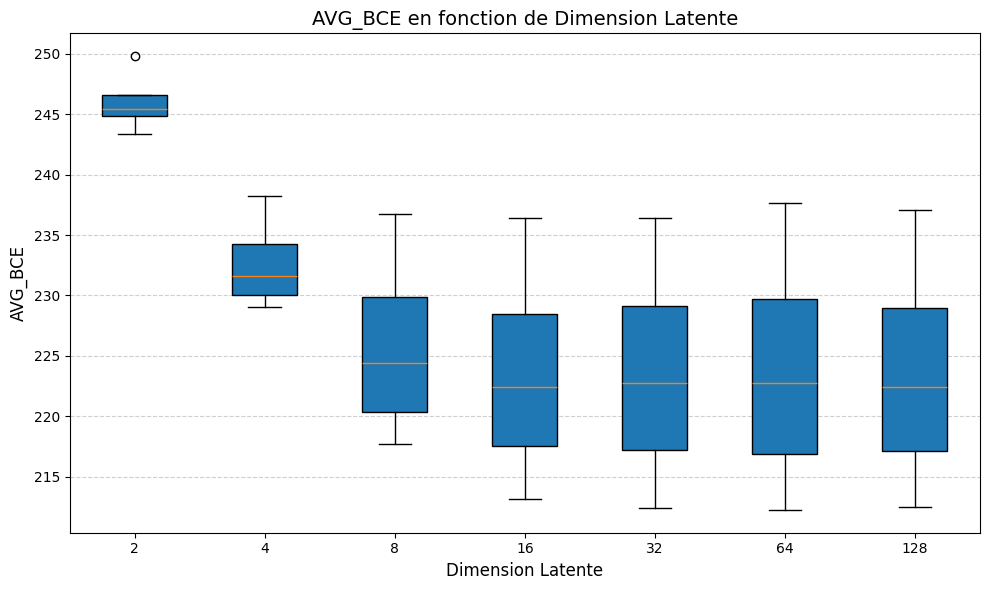

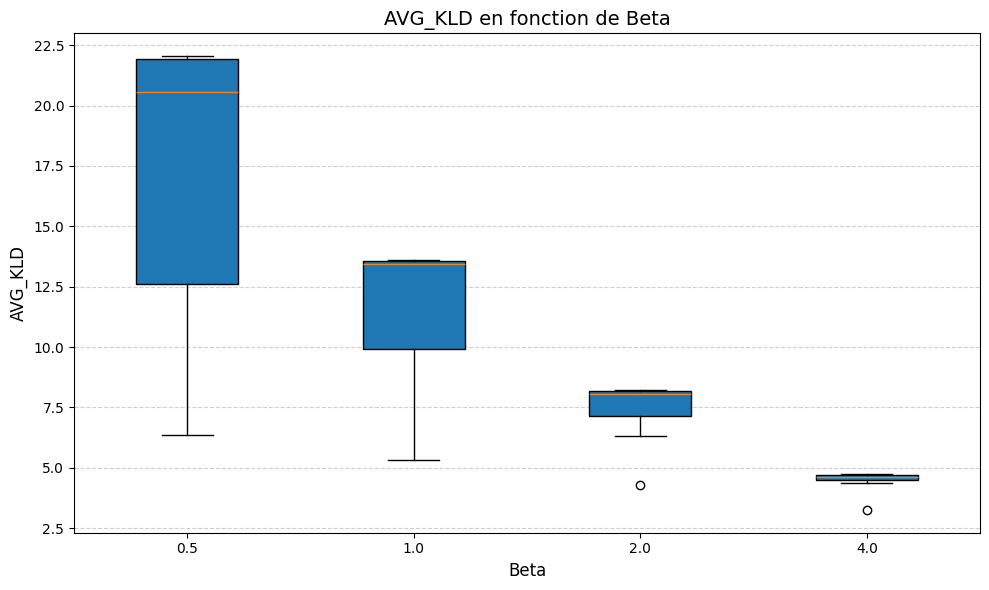

In [8]:
def evaluate_all_models(model_dir, test_loader, device):
    results = []
    for model_name in os.listdir(model_dir):
        if model_name.endswith(".pth"):
            latent_dim, beta = extract_hyperparameters(model_name)
            model_path = os.path.join(model_dir, model_name)
            model = load_model(model_path, latent_dim, device)
            avg_bce, avg_kld = evaluate_bce_kld(model, test_loader, device)
            results.append({
                "model_name": model_name,
                "latent_dim": latent_dim,
                "beta": beta,
                "avg_bce": avg_bce,
                "avg_kld": avg_kld
            })
    return results

def plot_metric_by_hyperparam_boxplot(results, metric, hyperparam, xlabel):
    grouped_results = defaultdict(list)
    for result in results:
        grouped_results[result[hyperparam]].append(result[metric])
    sorted_hyperparams = sorted(grouped_results.keys())
    data = [grouped_results[h] for h in sorted_hyperparams]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=sorted_hyperparams, showmeans=False, patch_artist=True)
    plt.title(f"{metric.upper()} en fonction de {xlabel}", fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(metric.upper(), fontsize=12)
    plt.grid(axis='y', linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

results = evaluate_all_models("./models", val_loader, device)
plot_metric_by_hyperparam_boxplot(results, metric="avg_bce", hyperparam="latent_dim", xlabel="Dimension Latente")
plot_metric_by_hyperparam_boxplot(results, metric="avg_kld", hyperparam="beta", xlabel="Beta")


Les résultats sont cohérents : une dimension latente plus élevée permet de capturer plus de caractéristiques aidant à la reconstruction de l'image, et un $\beta$ élevé tend à faire diminuer l'erreur KLD.

## 2.3. Sélection du meilleur modèle

Regardons les hyperparamètres qui donnent la plus faible val loss.

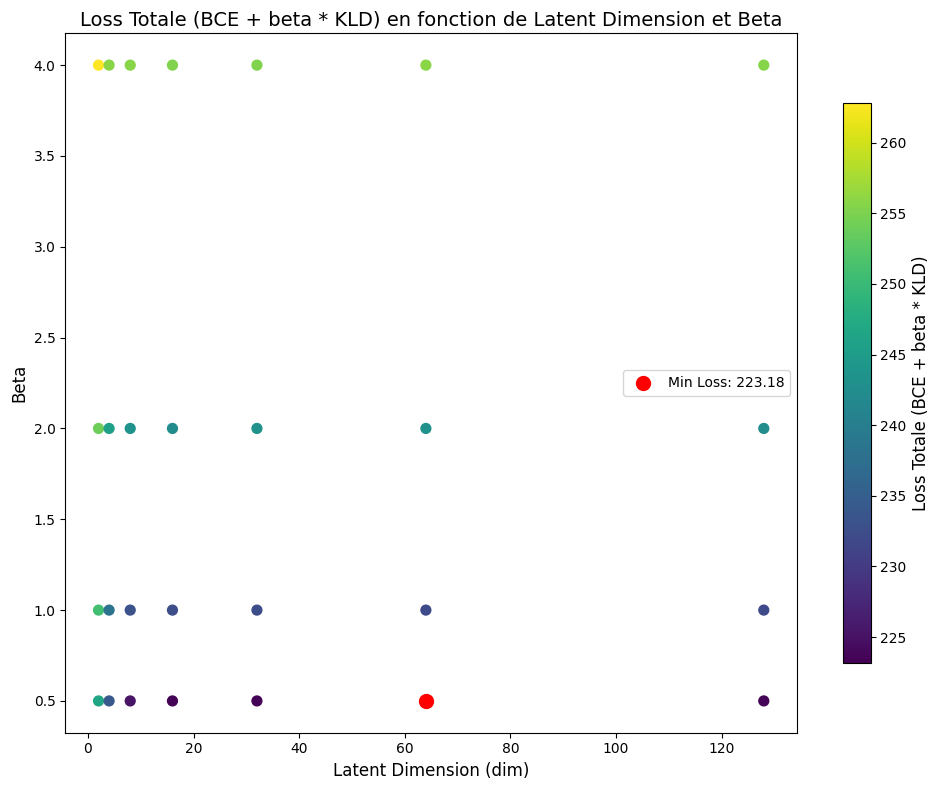

In [9]:
def plot_total_loss_2d(results):
    beta_values, dim_values, total_losses = [], [], []
    for result in results:
        beta_values.append(result["beta"])
        dim_values.append(result["latent_dim"])
        total_losses.append(result["avg_bce"] + result["beta"] * result["avg_kld"])

    beta_values, dim_values, total_losses = np.array(beta_values), np.array(dim_values), np.array(total_losses)
    min_loss_index = np.argmin(total_losses)
    min_loss, min_loss_beta, min_loss_dim = total_losses[min_loss_index], beta_values[min_loss_index], dim_values[min_loss_index]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(dim_values, beta_values, c=total_losses, cmap="viridis", s=50)
    plt.title("Loss Totale (BCE + beta * KLD) en fonction de Latent Dimension et Beta", fontsize=14)
    plt.xlabel("Latent Dimension (dim)", fontsize=12)
    plt.ylabel("Beta", fontsize=12)
    plt.scatter(min_loss_dim, min_loss_beta, color='red', s=100, label=f"Min Loss: {min_loss:.2f}")
    plt.legend(fontsize=10)
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label("Loss Totale (BCE + beta * KLD)", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_total_loss_2d(results)


Nous sélectionnons le modèle avec les meilleurs hyperparamètres, c'est-à-dire une dimension latente de 64 et un beta de 0.5.

In [10]:
best_cvae = models_dict[(64,0.5)]

# 3. Evaluation des performances du modèle sélectionné

Dans cette sections nous effectuons plusieurs tests permettant de rendre compte des capacités de reconstruction et de génération du modèle sélectionné.

## 3.1 Erreurs de reconstructions par classe

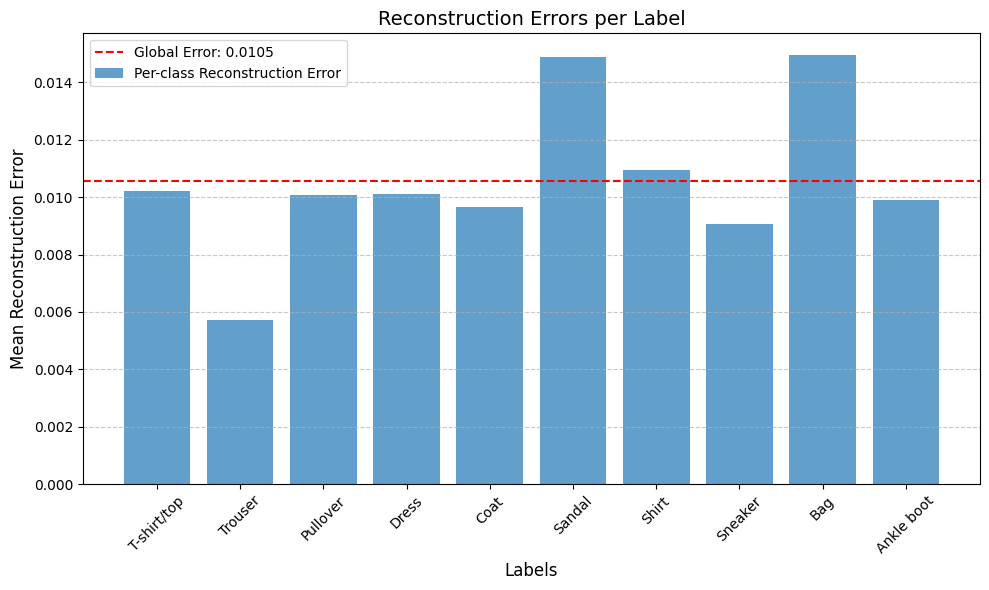

In [11]:
def calculate_reconstruction_errors(cvae, test_loader, device, num_classes=10):
    cvae.eval()
    reconstruction_errors = {label: [] for label in range(num_classes)}
    with torch.no_grad():
        all_data, all_labels = [], []
        for data, labels in test_loader:
            all_data.append(data)
            all_labels.append(labels)
        all_data, all_labels = torch.cat(all_data, dim=0), torch.cat(all_labels, dim=0)
        for idx in range(len(all_labels)):
            label = all_labels[idx].item()
            image = all_data[idx].unsqueeze(0).to(device)
            recon, _, _ = cvae(image, torch.tensor([label]).to(device))
            error = F.mse_loss(recon, image, reduction='mean').item()
            reconstruction_errors[label].append(error)
    global_error = sum(sum(errors) for errors in reconstruction_errors.values()) / sum(len(errors) for errors in reconstruction_errors.values())
    class_errors = {label: (sum(reconstruction_errors[label]) / len(reconstruction_errors[label])) if reconstruction_errors[label] else 0 for label in reconstruction_errors}
    return global_error, class_errors

def plot_reconstruction_errors(cvae, test_loader, device, num_classes=10):
    global_error, class_errors = calculate_reconstruction_errors(cvae, test_loader, device, num_classes)
    labels = list(range(num_classes))
    errors = [class_errors[label] for label in labels]
    label_names_list = [label_names[label] for label in labels]
    plt.figure(figsize=(10, 6))
    plt.bar(label_names_list, errors, alpha=0.7, label='Per-class Reconstruction Error')
    plt.axhline(y=global_error, color='r', linestyle='--', label=f'Global Error: {global_error:.4f}')
    plt.title('Reconstruction Errors per Label', fontsize=14)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Mean Reconstruction Error', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_reconstruction_errors(best_cvae, test_loader, device)


On remarque que la classe Sandal et Bag ont plus de difficultés à être reconstruites, néanmoins on a une bonne erreur de reconstruction au global. Observons cela visuellement.

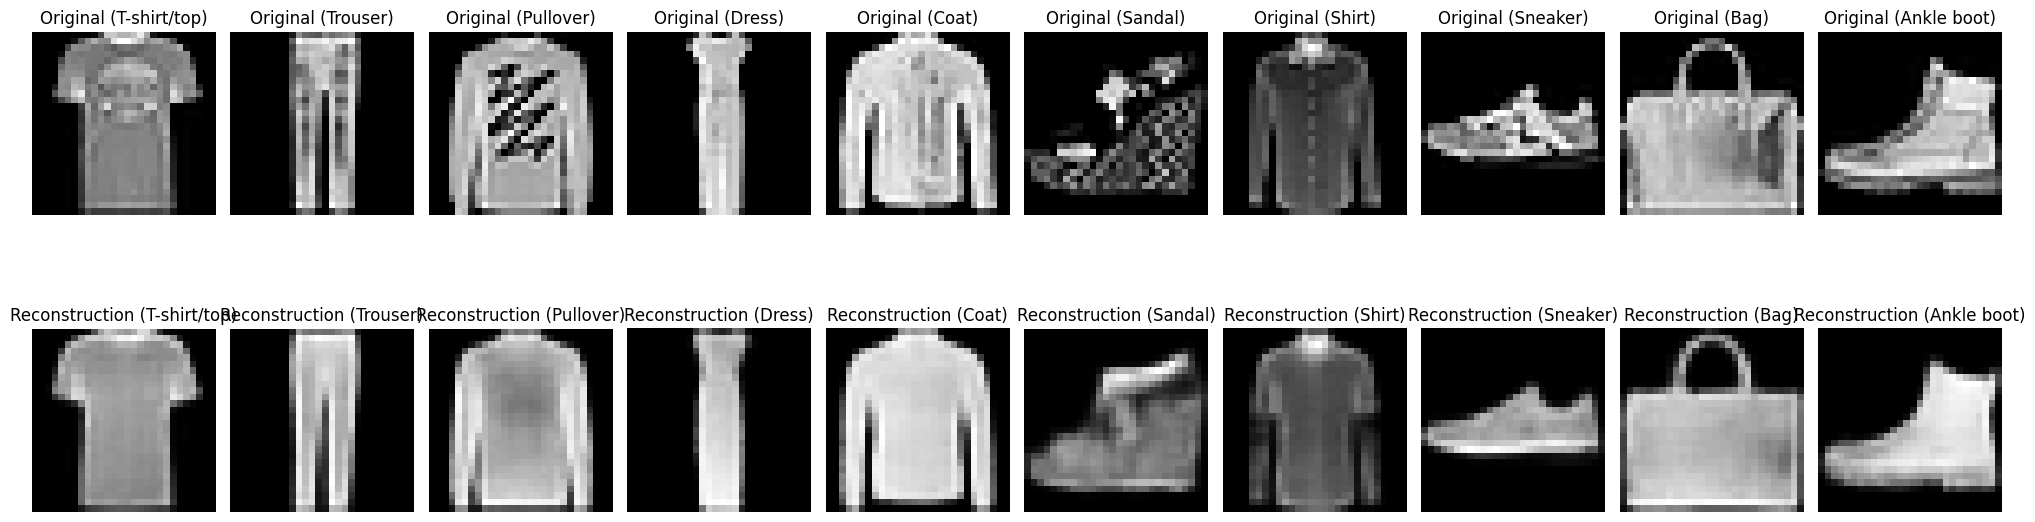

In [12]:
def visualize_random_reconstructions(cvae, test_loader, device, num_classes=10):
    cvae.eval()
    label_images = {}

    with torch.no_grad():
        all_data, all_labels = zip(*[(data, labels) for data, labels in test_loader])
        all_data = torch.cat(all_data)
        all_labels = torch.cat(all_labels)

        for idx in torch.randperm(len(all_labels)):
            label = all_labels[idx].item()
            if label not in label_images:
                label_images[label] = all_data[idx]
            if len(label_images) == num_classes:
                break

        fig, axs = plt.subplots(2, num_classes, figsize=(20, 7))
        for label, image in label_images.items():
            image = image.unsqueeze(0).to(device)
            recon, _, _ = cvae(image, torch.tensor([label]).to(device))
            for i, img in enumerate([image, recon]):
                axs[i, label].imshow(img.cpu().squeeze(), cmap='gray')
                axs[i, label].axis('off')
                title = f'{"Original" if i == 0 else "Reconstruction"} ({label_names[label]})'
                axs[i, label].set_title(title)
        plt.tight_layout()
        plt.show()

visualize_random_reconstructions(best_cvae, test_loader, device)

La visualisation confirme une reconstruction plutôt fidèle des images.

## 3.2. Génération d'images par classe

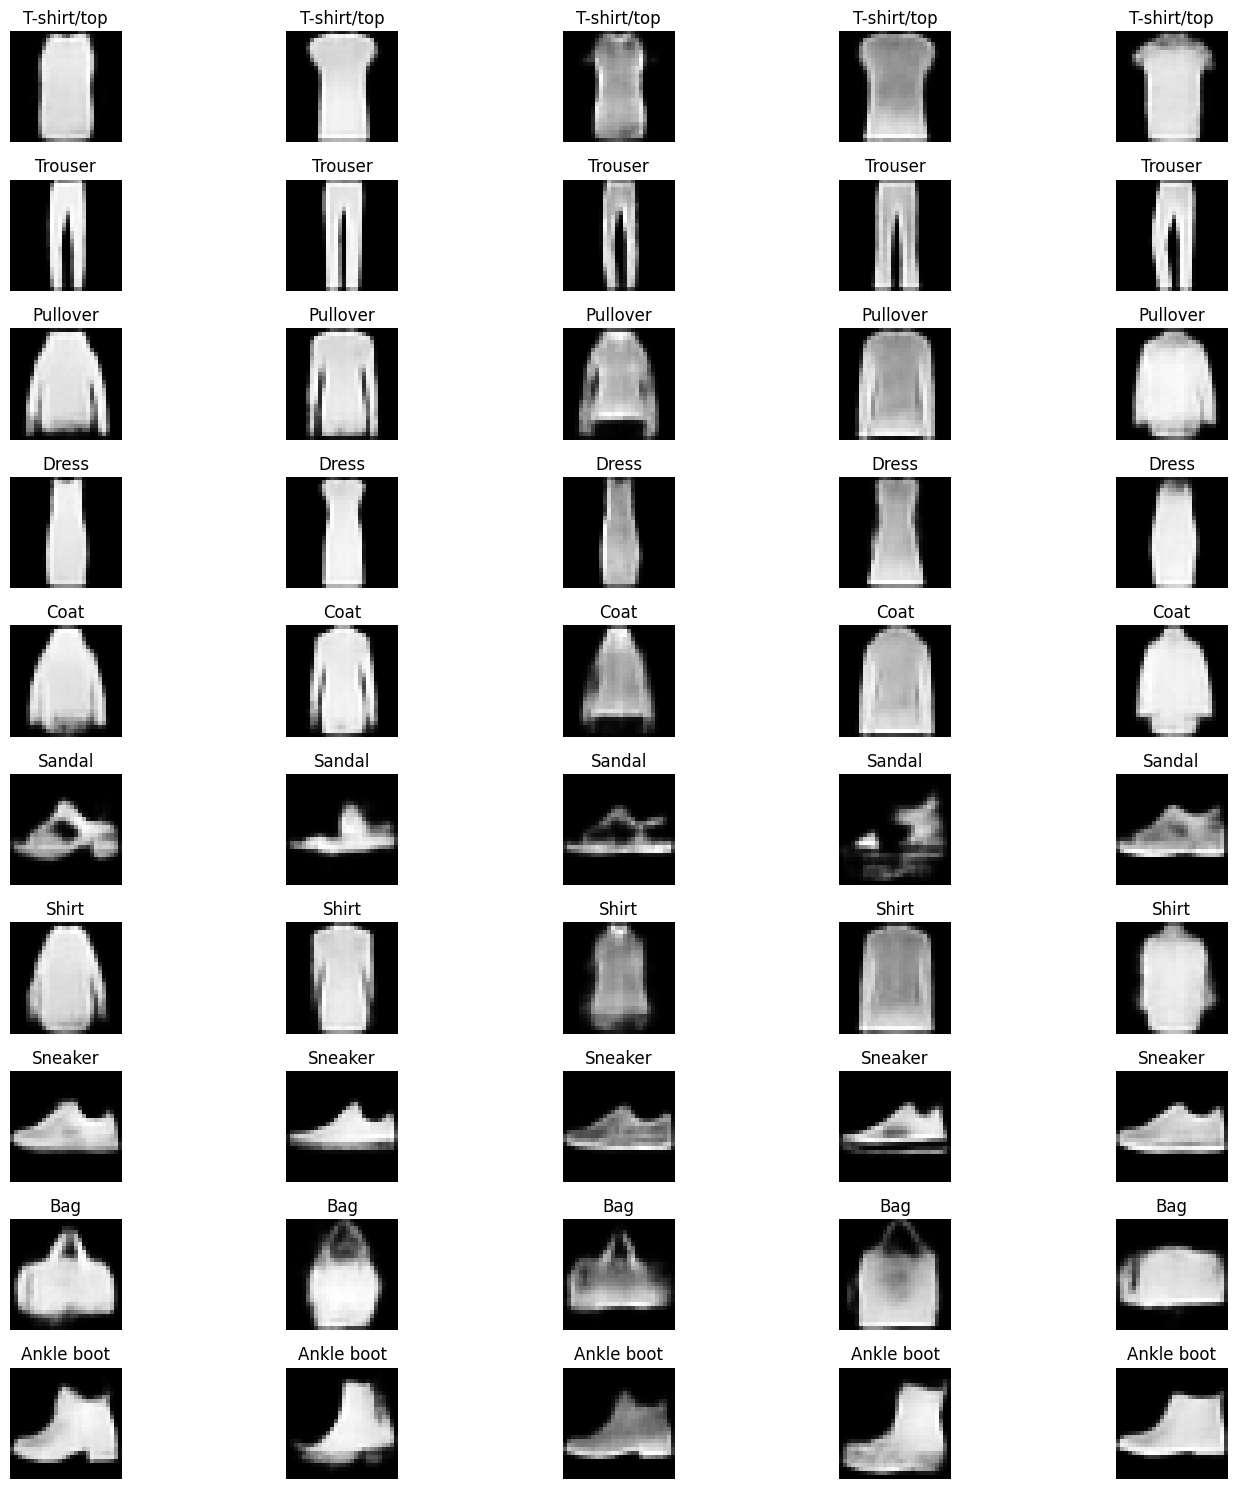

In [13]:
def generate_sample(cvae, device, latent_dim=64, num_classes=10, num_samples_per_class=5):
    cvae.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 15))
        z = torch.randn(num_samples_per_class, latent_dim).to(device)
        for label in range(num_classes):
            samples = cvae.decode(z, torch.tensor([label] * num_samples_per_class).to(device))
            samples = samples.cpu().view(num_samples_per_class, 1, 28, 28)

            for i in range(num_samples_per_class):
                axs[label, i].imshow(samples[i].squeeze(0), cmap='gray')
                axs[label, i].set_title(label_names[label]) # Use label name here
                axs[label, i].axis('off')

        plt.tight_layout()
        plt.show()

# Call the function
generate_sample(best_cvae, device)

Les générations semblent plutôt bonnes, sauf pour Sandal et Bag qui semblent plus difficiles à générer, cohérent avec la difficulté de reconstruction vue plus tôt.

## 3.3 Interpolation dans l'espace latent

L'interpolation dans l'espace latent consiste à générer une série d'échantillons intermédiaires en effectuant une transition linéaire entre deux vecteurs latents, permettant d'observer comment le modèle capture les variations continues entre deux représentations dans l'espace latent.

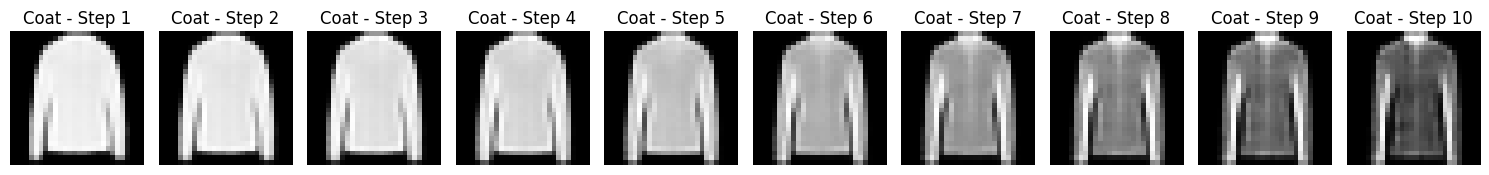

In [14]:
def visualize_latent_interpolation(cvae, device, latent_dim=64, num_steps=10, label=0, use_labels=True):
    cvae.eval()
    with torch.no_grad():
        z_start = torch.randn(1, latent_dim).to(device)
        z_end = torch.randn(1, latent_dim).to(device)
        interpolated_z = torch.stack([z_start * (1 - alpha) + z_end * alpha for alpha in torch.linspace(0, 1, num_steps)]).squeeze(1)
        label_tensor = torch.tensor([label] * num_steps if use_labels else [0] * num_steps).to(device)
        samples = cvae.decode(interpolated_z, label_tensor).cpu().view(num_steps, 1, 28, 28)
        fig, axs = plt.subplots(1, num_steps, figsize=(15, 5))
        for i in range(num_steps):
            axs[i].imshow(samples[i].squeeze(0), cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f"{label_names[label]} - Step {i + 1}" if use_labels else f"Step {i + 1}")
        plt.tight_layout()
        plt.show()

# Example usage
visualize_latent_interpolation(best_cvae, device, latent_dim=64, num_steps=10, label=random.randint(0, 9), use_labels=True)


La réprésentation latente reste cohérente le long de la transition linéaire et traduit un espace latent bien construit.

## 3.4 Visualisation de l'espace latent

Regardons les données dans l'espace latent projeté sur les deux premières composantes principales.

Explained variance ratio : [0.24466485 0.23886646]


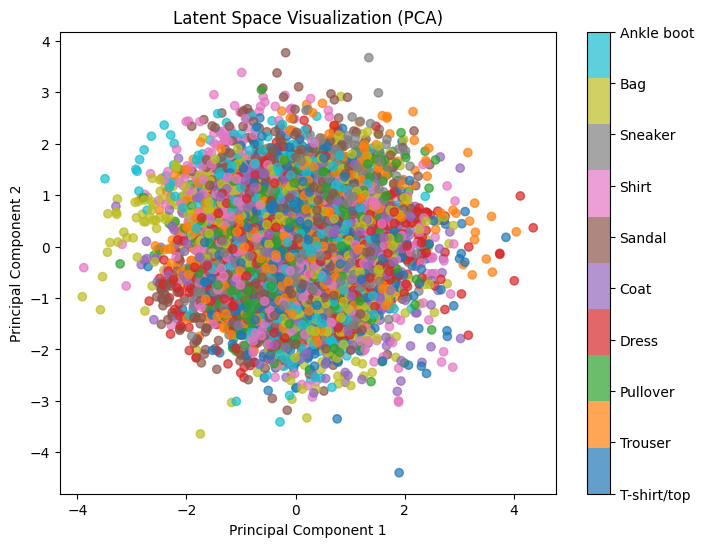

In [15]:
def plot_latent_space_with_pca(model, test_dataset, device="cuda"):
    model.eval()
    with torch.no_grad():
        # Charger les données et les labels
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data, labels = data.to(device), labels.to(device)
        mu, logvar = model.encode(data, labels)
        z = mu.cpu().numpy()  # Récupération des données latentes
        labels = labels.cpu().numpy()
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)
        print(f"Explained variance ratio : {pca.explained_variance_ratio_}")
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
        colorbar = plt.colorbar(scatter)
        tick_locs = (colorbar.get_ticks()).astype(int)  # Obtenir les positions des ticks
        tick_labels = [label_names.get(tick, f"Unknown ({tick})") for tick in tick_locs]
        colorbar.set_ticks(tick_locs)
        colorbar.set_ticklabels(tick_labels)
        plt.title('Latent Space Visualization (PCA)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

plot_latent_space_with_pca(model, test_dataset)

La forme en ellipse suggère une distribution normale, d'autant plus que l'ellipse est centrée en zéro. Cependant les labels semblent mal séparés.

## 3.5 Encodage une classe puis décodage en une autre

Afin de tester l'efficacité du conditionnement pour le décodage, nous regardons le résultat d'un encodage d'un vêtement d'une classe donnée et de son décodage dans toutes les autres classes.

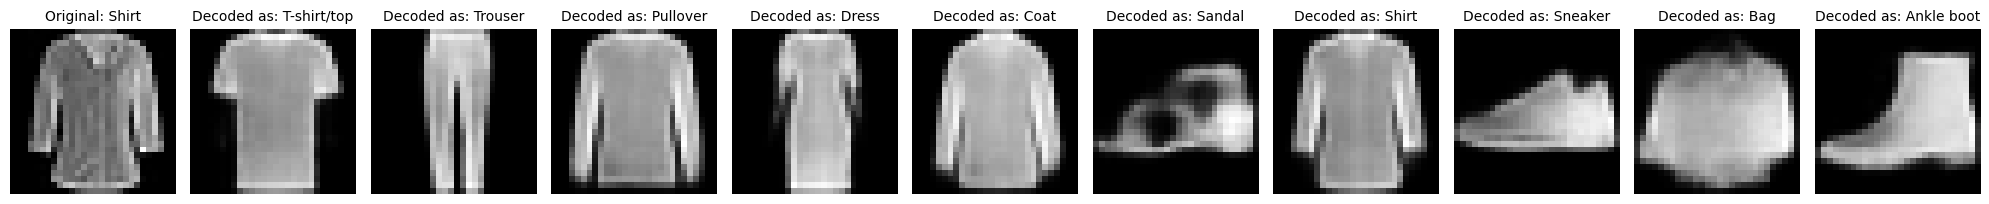

In [16]:
def test_cross_class_decoding(cvae, data_loader, device, label_names, latent_dim=64, num_classes=10, selected_label=0):
    cvae.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            mask = labels == selected_label
            if mask.any():
                selected_image = images[torch.where(mask)[0][0]:torch.where(mask)[0][0]+1].to(device)
                break
        else:
            raise ValueError(f"No image found with label {selected_label} in the dataset.")
        
        z = cvae.encode(selected_image, torch.tensor([selected_label]).to(device))[0]
        new_labels = torch.arange(0, num_classes).to(device)
        decoded_images = cvae.decode(z.repeat(num_classes, 1), new_labels).cpu().view(num_classes, 1, 28, 28)
        
        fig, axs = plt.subplots(1, num_classes + 1, figsize=(20, 4))
        axs[0].imshow(selected_image.cpu().squeeze(), cmap='gray')
        axs[0].axis('off')
        axs[0].set_title(f"Original: {label_names[selected_label]}", fontsize=10)
        for i in range(num_classes):
            axs[i + 1].imshow(decoded_images[i].squeeze(0), cmap='gray')
            axs[i + 1].axis('off')
            axs[i + 1].set_title(f"Decoded as: {label_names[i]}", fontsize=10)
        plt.tight_layout()
        plt.show()

test_cross_class_decoding(best_cvae, test_loader, device, label_names, latent_dim=64, num_classes=10,selected_label = random.randint(0, 9))

Le condtionnement semble influer de manière efficace pour le décodage d'un vecteur latent.

## 3.6 Evaluation du score FID

Le score FID (Fréchet Inception Distance) est une métrique utilisée pour évaluer la qualité des images générées par un modèle, comme les VAEs ou GANs, en les comparant à un ensemble d'images réelles. Il mesure la distance entre les distributions statistiques des caractéristiques extraites d'un réseau de classification pré-entraîné (souvent Inception-v3) pour les images réelles et générées. Plus précisément, il calcule la distance Fréchet entre les deux distributions gaussiennes, en prenant en compte les moyennes et covariances des caractéristiques. Un score FID plus faible indique que les images générées sont plus similaires aux images réelles, en termes de contenu et de diversité.

La distance de Fréchet est définie par la formule suivante :

$$
\text{FID} = \|\mu_r - \mu_g\|_2^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2 (\Sigma_r \Sigma_g)^{1/2})
$$

où :
- $ \mu_r $ et $ \Sigma_r $ sont respectivement la moyenne et la matrice de covariance des caractéristiques des images réelles.
- $ \mu_g $ et $ \Sigma_g $ sont respectivement la moyenne et la matrice de covariance des caractéristiques des images générées.
- $ \|\mu_r - \mu_g\|_2^2 $ est la distance euclidienne au carré entre les moyennes.
- $ \text{Tr}(\cdot) $ représente la trace d'une matrice.
- $ (\Sigma_r \Sigma_g)^{1/2} $ est la racine carrée du produit matriciel des covariances.


In [17]:
real_images_dir = './fid_real_images'
generated_images_dir = './fid_generated_images'

os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(generated_images_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 64
model = best_cvae.to(device)
model.eval()

if not os.listdir(real_images_dir):
    for i, (images, _) in enumerate(tqdm(test_loader)):
        for j in range(images.size(0)):
            save_image(images[j], f"{real_images_dir}/real_{i * test_loader.batch_size + j}.png")

if not os.listdir(generated_images_dir):
    num_samples = len(test_dataset)
    labels = torch.arange(10).repeat(num_samples // 10 + 1)[:num_samples].to(device)
    for i in tqdm(range(0, num_samples, 128)):
        z = torch.randn(128, latent_dim).to(device)
        batch_labels = labels[i:i + 128]
        generated_images = model.decode(z[:len(batch_labels)], batch_labels)
        for j in range(generated_images.size(0)):
            save_image(generated_images[j], f"{generated_images_dir}/generated_{i + j}.png")

fid_value = fid_score.calculate_fid_given_paths([real_images_dir, generated_images_dir],
                                                batch_size=128,
                                                device=device,
                                                dims=2048)
print(f"FID Score: {fid_value}")

100%|███████████████████████████████████████████| 79/79 [00:21<00:00,  3.69it/s]


FID Score: 45.716297471183026


On oberve un score FID de 46, ce qui est raisonnable mais améliorable (pour des images simples comme FashionMnist, un algorithme plus complexe de génération style GAN pourrait facilement atteindre des scores FID de 10 à 20).

Pour obtenir des éléments d'explication de ce score, regardons, d'une part la capacité du CVAE à produire des images identifiables en tentant de les classifier (partie 3.7), puis d'autre part la capacité à produire des images variées en comparant les variances des réprésentations latentes des images réelles et générées (partie 3.8).

## 3.7 Score de classification des images générées

Pour vérifier la qualité des images générées, on entraîne un CNN à classifier les images réelles puis on regarde s'il classifie efficacement les images générées.

### 3.7.1 Définition du CNN

In [18]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))))
        x = self.pool2(self.relu(self.bn4(self.conv4(self.relu(self.bn3(self.conv3(x)))))))
        x = self.pool3(self.relu(self.bn6(self.conv6(self.relu(self.bn5(self.conv5(x)))))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn_fc2(self.fc2(x))))
        return self.fc3(x)


### 3.7.2 Entraînement et sauvegarde du modèle

In [20]:
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = sum(criterion(model(images.to(device)), labels.to(device)).item() 
                         for images, labels in train_loader) / len(train_loader)
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images.to(device))
                val_loss += criterion(outputs, labels.to(device)).item()
                correct += (outputs.argmax(1) == labels.to(device)).sum().item()
                total += labels.size(0)
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                model.load_state_dict(torch.load("best_model.pth"))
                return

if train:
    model = FashionCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=10)

cnn = FashionCNN()
cnn.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

### 3.7.3 Classification sur le data set et sur des images générées

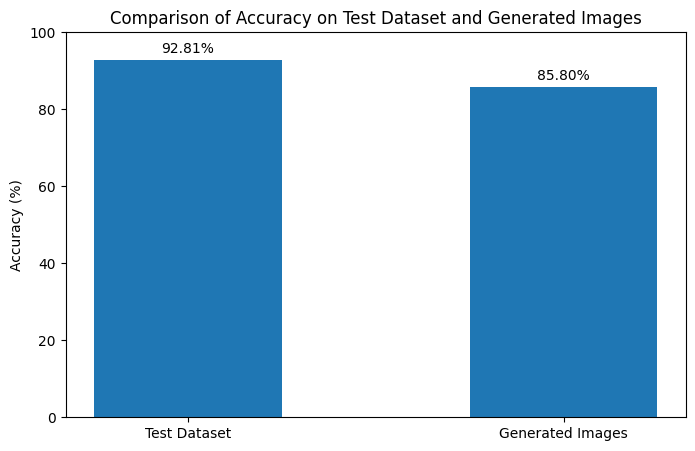

In [21]:
def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            correct += (outputs.argmax(1) == labels.to(device)).sum().item()
            total += labels.size(0)
    return correct / total

def generate_images(cvae, num_images=1000):
    cvae.eval()
    device = next(cvae.parameters()).device
    labels = torch.arange(0, cvae.num_classes).repeat_interleave(num_images).to(device)
    z = torch.randn(len(labels), cvae.latent_dim).to(device)
    return cvae.decode(z, labels), labels

def classify_generated_images(cvae, cnn, num_images=1000):
    gen_images, labels = generate_images(cvae, num_images=num_images)
    outputs = cnn(gen_images.to(next(cvae.parameters()).device))
    return (outputs.argmax(1) == labels).float().mean().item()

test_accuracy = test_model(cnn, test_loader)
generated_accuracy = classify_generated_images(best_cvae, cnn, num_images=100)
accuracies = [100 * test_accuracy, 100 * generated_accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(['Test Dataset', 'Generated Images'], accuracies, width=0.5)
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Accuracy on Test Dataset and Generated Images')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 1, f'{bar.get_height():.2f}%', ha='center', va='bottom')
plt.show()


On observe des performances de classification légèrement inférieures sur les images générées que sur le data test, traduisant le fait que le CVAE génère des images assez reconnaissables dans l'ensemble mais un peu moins que celles du data test.

## 3.8 Diversité des données générées

Afin de voir si les données générées sont aussi diversifiées que les images réelles, nous affichons la variance globale et intra-classe des représentation latentes $\mu$ des images réelles et générées.

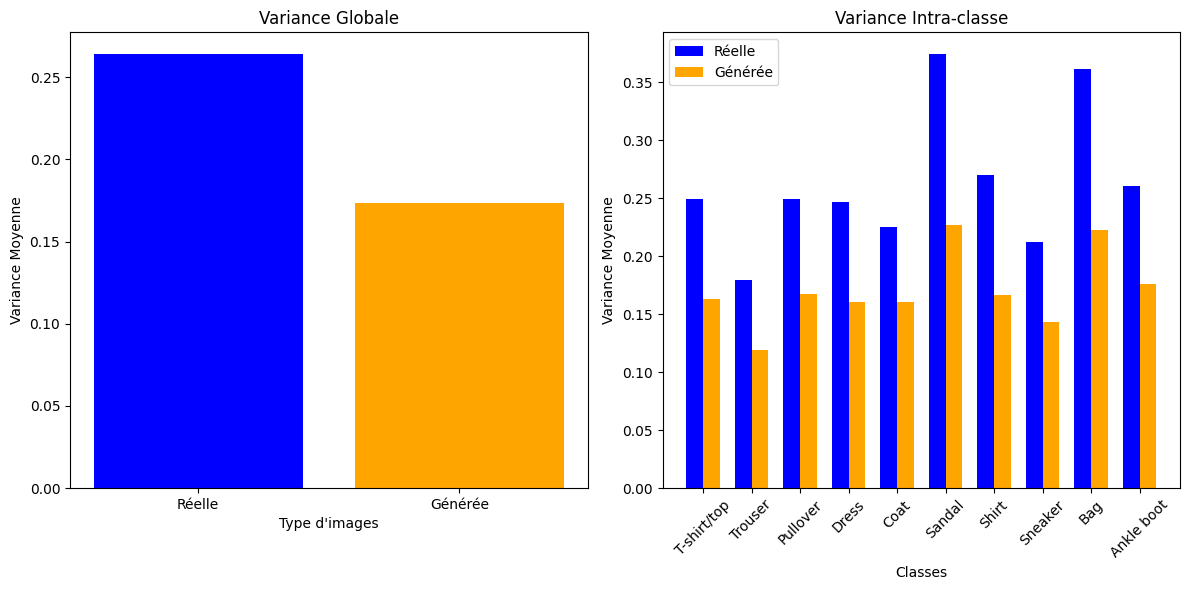

In [22]:
def generate_images(model, num_samples, latent_dim, device):
    labels = torch.arange(10).repeat(num_samples // 10 + 1)[:num_samples].to(device)
    z = torch.randn(num_samples, latent_dim).to(device)
    generated_images = [model.decode(z[i:i + 128], labels[i:i + 128]).cpu() for i in range(0, num_samples, 128)]
    return torch.cat(generated_images, dim=0), labels.cpu()

def encode_latents(model, images, labels, device):
    latents = [model.encode(images[i:i + 128].to(device), labels[i:i + 128].to(device))[0].detach().cpu().numpy() 
               for i in range(0, images.size(0), 128)]
    return np.concatenate(latents, axis=0)

def compute_intra_class_variance(latents, labels):
    return [np.var(latents[labels == c], axis=0).mean() if len(latents[labels == c]) > 1 else 0.0 
            for c in np.unique(labels)]

def plot_variances(real_variance_global, generated_variance_global, real_variance_intra, generated_variance_intra, label_names):
    classes = list(label_names.values())
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(['Réelle', 'Générée'], [real_variance_global, generated_variance_global], color=['blue', 'orange'])
    plt.title('Variance Globale')
    plt.ylabel('Variance Moyenne')
    plt.xlabel('Type d\'images')
    plt.subplot(1, 2, 2)
    x = np.arange(len(classes))
    plt.bar(x - 0.35 / 2, real_variance_intra, 0.35, label='Réelle', color='blue')
    plt.bar(x + 0.35 / 2, generated_variance_intra, 0.35, label='Générée', color='orange')
    plt.xticks(x, classes, rotation=45)
    plt.title('Variance Intra-classe')
    plt.ylabel('Variance Moyenne')
    plt.xlabel('Classes')
    plt.legend()
    plt.tight_layout()
    plt.show()

num_samples = 10000
generated_images, generated_labels = generate_images(best_cvae, num_samples, latent_dim, device)
real_latents = encode_latents(best_cvae, torch.stack([img for img, _ in test_dataset]), 
                              torch.tensor([label for _, label in test_dataset]), device)
generated_latents = encode_latents(best_cvae, generated_images, generated_labels, device)
real_variance_global = np.var(real_latents, axis=0).mean()
generated_variance_global = np.var(generated_latents, axis=0).mean()
real_variance_intra = compute_intra_class_variance(real_latents, 
                                                   np.array([label for _, label in test_dataset]))
generated_variance_intra = compute_intra_class_variance(generated_latents, generated_labels.numpy())
plot_variances(real_variance_global, generated_variance_global, real_variance_intra, generated_variance_intra, label_names)

On remarque des variances systématiquement inférieures pour les images générées que pour les images réelles du data test, ce qui signifie que l'on génère des images un peu moins diversifiées que la réalité.

En conclusion, le CVAE génère des images un peu moins reconnaissables et diverses par rapport à la réalité, ce qui explique son score FID plutôt moyen.